In [478]:
include("../src/celerite.jl")
using celerite
using Plots
using Distributions

ArgumentError: ArgumentError: Package celerite not found in current path:
- Run `Pkg.add("celerite")` to install the celerite package.


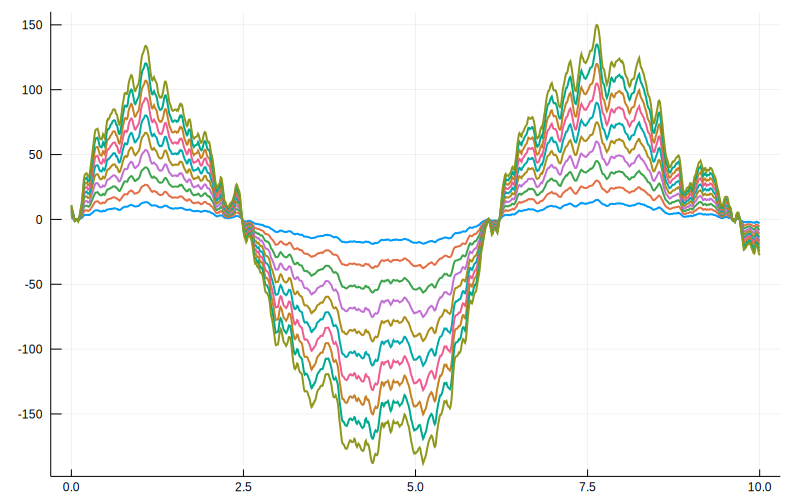

In [480]:
# parameters for kernel function
log_s = log(0.1)
log_q = log(1/sqrt(2))
log_w0 = 3

#a = [-0.519196, 63.119512, -32.173615, -29.425156]
#b = [0.285478, 0.0, 0.0, 0.0]
#c = [1.383928, 1.479579, 1.593691, 1.388929]
#d = [1.83396, 0.0, 0.0, 0.0]

# define the second dimension's covariance 
c = collect(1:1:10)
n = length(c)
Q = broadcast(*, c, c')
#Q = ones(1, 1)
#n = 1

# independent variable 
t = collect(0.0:0.01:10)

# define the gp
t1 = celerite.SHOTerm(log_s, log_q, log_w0)
t2 = celerite.SHOTerm(log(100), log(1/sqrt(2)), 0.1)

#t1 = celerite.ComplexTerm(1, 1, 1, 1)
#for i in 2:length(a)
#    t1 = t1 + celerite.ComplexTerm(a[i], b[i], c[i], d[i])
#end

u = randn(n*length(t))
gp = celerite.Celerite(t1+t2, Q)

# compute the gp
logD = celerite.compute!(gp, t, 0.1)
# sample the gp
y = celerite.simulate_gp(gp, u)

# plot the samples
using Plots
plot(size=(800, 500), legend=false)
for i in 1:n
    plot!(t, y[i,:], linewidth=2, linealpha=1)
end
#plot(t, y)
current()

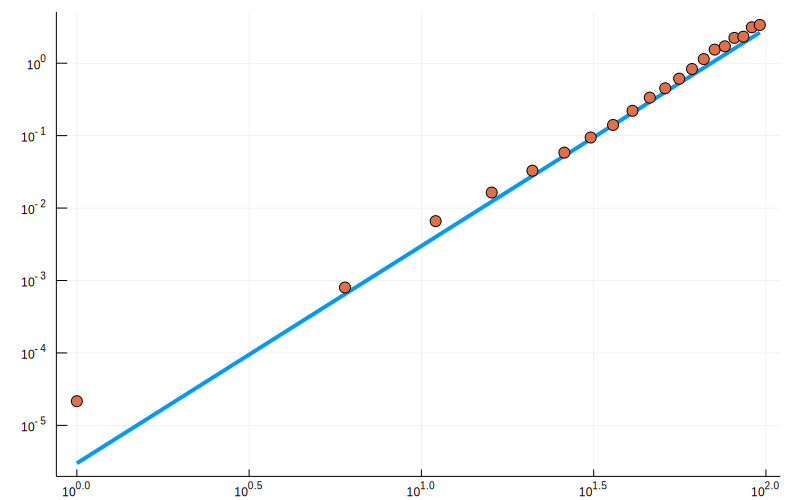

In [251]:
# time the computation as a function of the number of points in the second dimension, theoretical O(n^3)

# average computational time for n runs 
function time_compute(n, gp, t)
    sumtime = 0
    for i in 1:n
        sumtime += @elapsed celerite.compute!(gp, t, 0.01)
    end
    return sumtime/n
end

t = collect(0.0:0.1:10)
x = collect(1:5:100)
n = length(x)
time = zeros(n)

for (i, m) in enumerate(x)
    Q = ones(m, m)
    gp = celerite.Celerite(t1, Q)
    time[i] = time_compute(10, gp, t)
end

plot(x, 3e-6*x.^3, linewidth=4)
plot!(x, time, xscale=:log10, yscale=:log10, markershape=:circle, markersize=6, linewidth=0, legend=false, size=(800, 500))

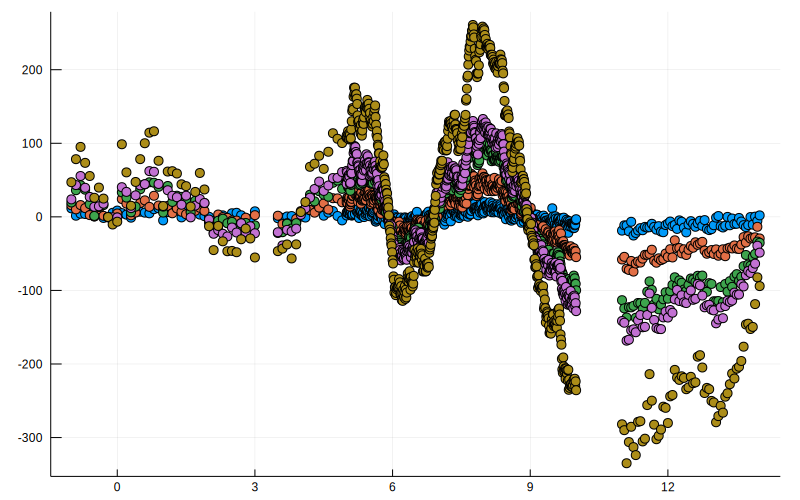

In [484]:
# prediction 

# create training set
t = vcat(collect(-1:0.1:3), collect(3.5:0.1:5), collect(5:0.01:10), collect(11:0.05:14))
c = [1, 4, 8, 10, 20]
Q = broadcast(*, c, c')
n = length(Q[1,:])
gp = celerite.Celerite(t1+t2, Q)
logD = celerite.compute!(gp, t, 5)
u = randn(n*length(t))
y = celerite.simulate_gp(gp, u)
y_noisy = y
plot(size=(800,500), legend=false)
for i in 1:n
    plot!(t, y_noisy[i,:], markershape=:circle, markersize=5, linewidth=0, markeralpha=1)
end
current()

In [485]:
using Optim

y = y_noisy
true_params = [log_s, log_q, log_w0, log(0.1), log(1/sqrt(2)), 3, log(4), log(8), log(10), log(20), log(5)]

function setup_gp(p)
    t1 = celerite.SHOTerm(p[1], p[2], p[3])
    t2 = celerite.SHOTerm(p[4], p[5], p[6])
    c = exp.([0., p[7], p[8], p[9], p[10]])
    Q = broadcast(*, c, c')
    gp = celerite.Celerite(t1+t2, Q)
    celerite.compute!(gp, t, exp(p[11]))
    return gp
end

function nll(p)
    gp = setup_gp(p)
    ret = -celerite.log_likelihood(gp, y)
    return ret  
end

initial_guess = ones(length(true_params))
lower = -Inf*initial_guess
upper = Inf*initial_guess
lower[end] = -1.

res = optimize(nll, lower, upper, initial_guess, NelderMead())

println("true kernel params: ", true_params[1:6])
println("best fit kernel params: ", res.minimizer[1:6])
println()
println("true scale factors: ", exp.(true_params[7:10]))
println("best fit scale factors", exp.(res.minimizer[7:10]))
println()
println("true jitter: ", exp.(true_params[11]))
println("best fit jitter: ", exp.(res.minimizer[11]))

true kernel params: [-2.30259, -0.346574, 3.0, -2.30259, -0.346574, 3.0]
best fit kernel params: [-0.38678, -1.68606, -0.755708, 5.07073, -2.33367, 1.25382]

true scale factors: [4.0, 8.0, 10.0, 20.0]
best fit scale factors[3.95226, 7.98811, 9.94537, 19.8887]

true jitter: 5.0
best fit jitter: 5.023053610817524


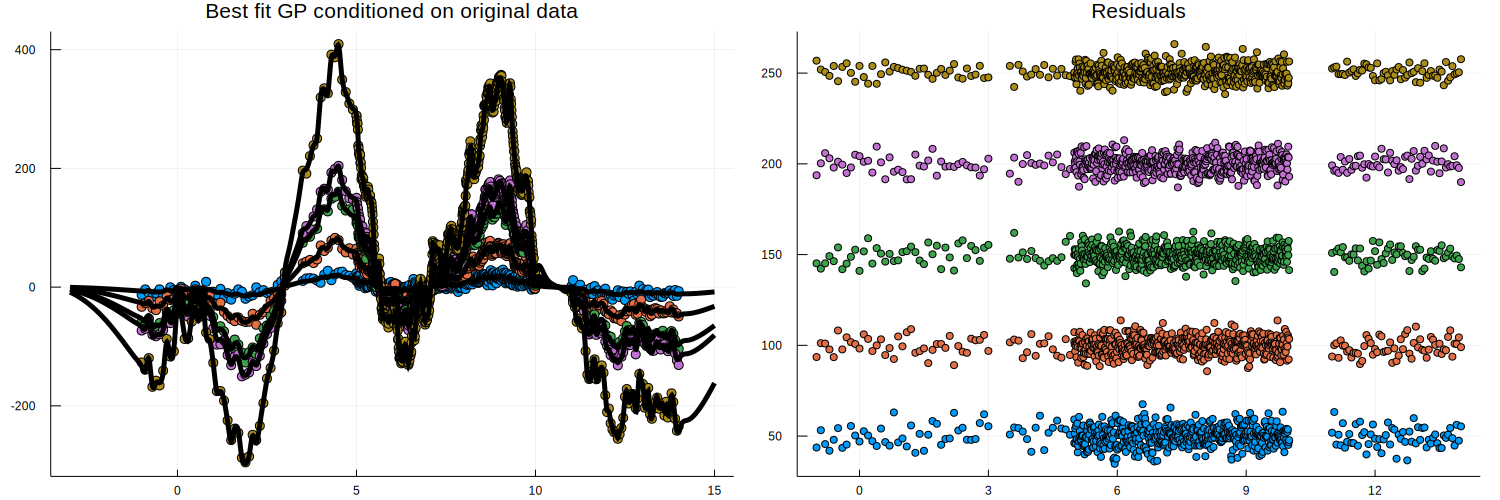

In [477]:
# maximum likelihood gp conditioned on original data: 
p1 = plot(legend=false, title = "Best fit GP conditioned on original data")
for i in 1:n
    plot!(t, y[i:n:end], markershape=:circle, markersize=5, linewidth=0, markeralpha=1)
end

# predict
x = collect(-3:0.01:15)
pred = celerite.predict!(gp, y, t, x)
for i in 1:n
    plot!(x, pred[i,:], linewidth=5, linealpha=1, color=:black)
end

p2 = plot(legend=false, title = "Residuals")
pred = celerite.predict!(gp, y, t, t)
for i in 1:n
    plot!(t, y[i,:] - pred[i,:] .+ 50*i, linewidth=0, marker=:circle, linealpha=1)
end

println()
plot(p1, p2, layout = 2, size=(1500, 500))

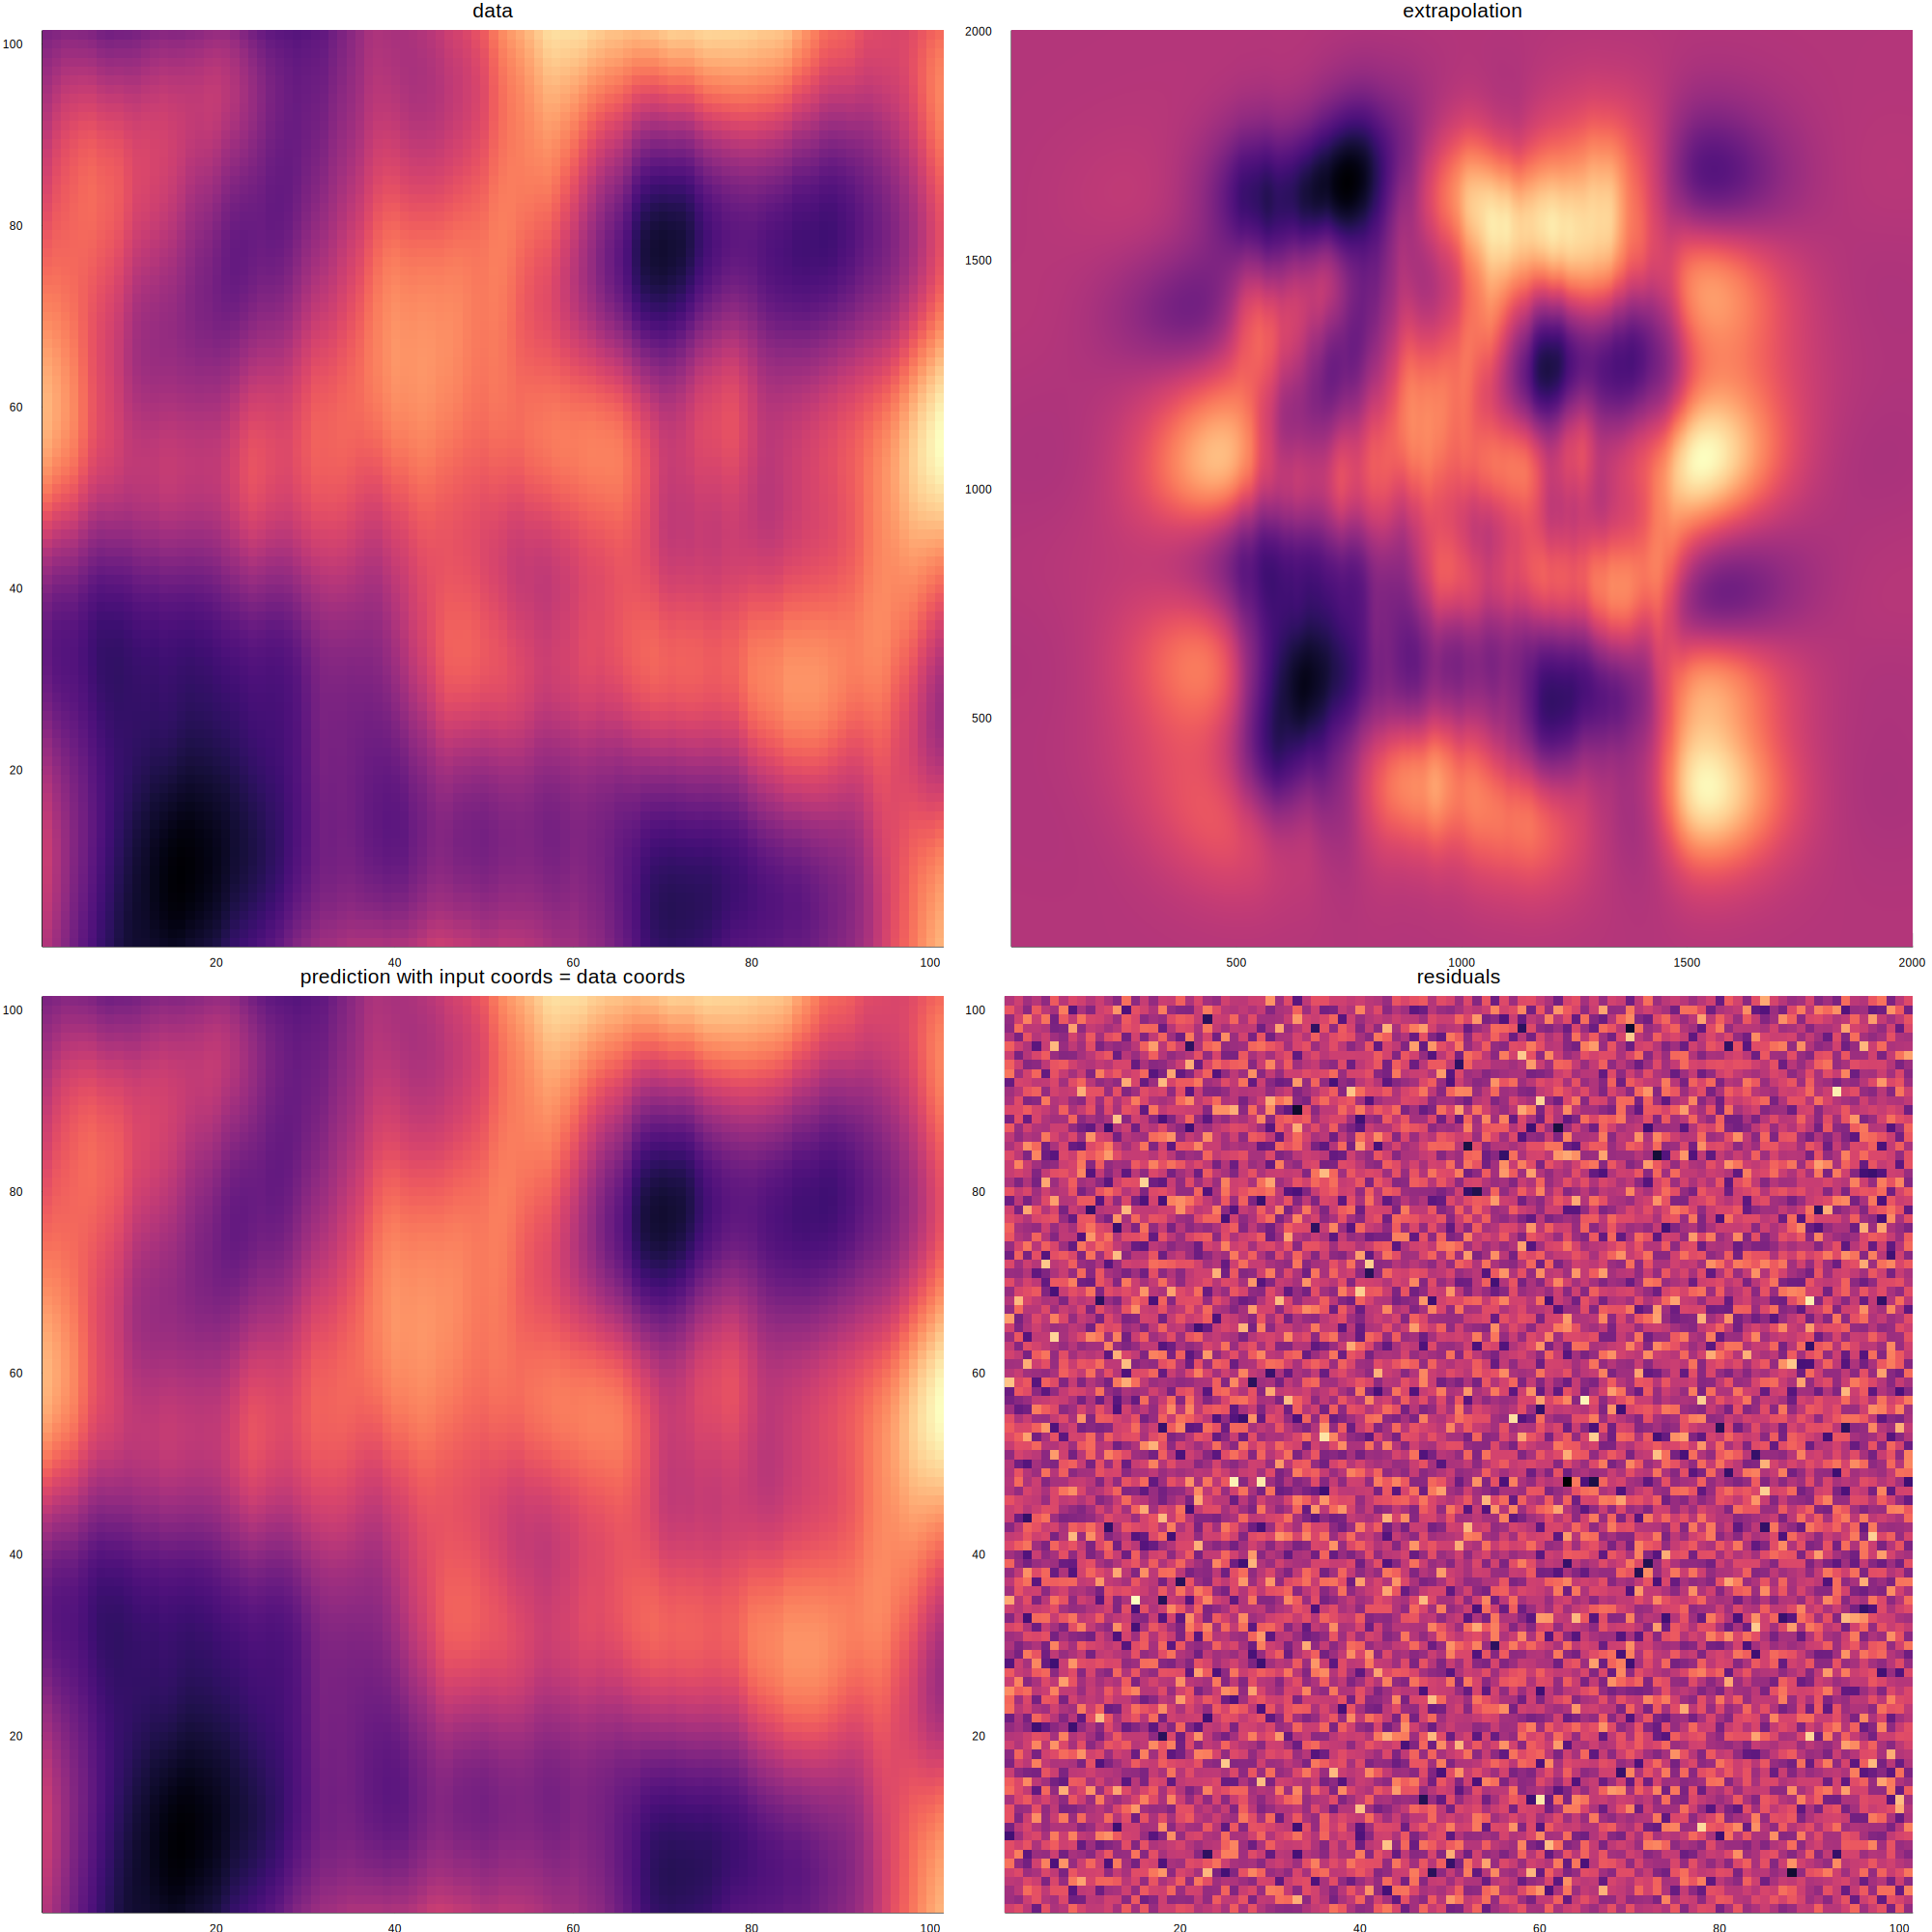

In [451]:
using Plots

# parameters for kernel function
log_s = log(0.1)
log_q = log(1/sqrt(2))
log_w0 = 0.1
amp = 1.0
dev = 2.0

# independent variable 
t = collect(0.0:0.1:10)
u = collect(0.0:0.1:10)
Q = make_cov_gauss(amp, dev, u)
n = length(u)

# define the gp
t1 = celerite.SHOTerm(log_s, log_q, log_w0)
x = randn(n*length(t))
gp = celerite.Celerite(t1+t2, Q)

# compute the gp
logD = celerite.compute!(gp, t, 0.01)
# sample the g2
y = celerite.simulate_gp(gp, x)

# plot the samples
p1 = plot(y, st=:heatmap, color=:magma, legend=false, title="data")

# define grid of input coordinates for prediction 
s = collect(-5:0.01:15)
v = collect(-5:0.01:15)

# kernel function for second dimension 
function kern(a, b)
    return amp*exp(-0.5*((a - b)^2)/dev)
end

# prediction 
pred = celerite.predict!(gp, y, t, s, u, v, kern)
p2 = plot(pred, st=:heatmap, color=:magma, legend=false, title="extrapolation")

# prediction with data coordinates equal to input coordinates 
pred = celerite.predict!(gp, y, t, t, u, u, kern)
p3 = plot(pred, legend=false, st=:heatmap, color=:magma, title="prediction with input coords = data coords")

# plot residuals
p4 = plot(pred - y, st=:heatmap, legend=false, color=:magma, title="residuals")

plot(p1, p2, p3, p4, layout = 4, size=(2000, 2000))

In [453]:
collect(1:10)

10-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10